<a href="https://colab.research.google.com/github/Carvas91/PyTroch/blob/main/L1_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,  TensorDataset
import seaborn as sns

In [2]:
iris = sns.load_dataset('iris')

data = torch.tensor(iris[iris.columns[0:4]].values).float()
labels = torch.zeros(len(data),dtype=torch.long)
labels[iris.species == 'virginica'] = 2
labels[iris.species == 'versicolor'] = 1
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

In [3]:
data_train, data_test, labels_train, labels_test =train_test_split(data, labels, test_size=0.2)

train_data = TensorDataset(data_train, labels_train)
test_data = TensorDataset(data_test, labels_test)

train_loader = DataLoader(train_data, batch_size=64, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])



In [4]:
def createModel():
  ANNiris = nn.Sequential(
      nn.Linear(4,64),
      nn.ReLU(),
      nn.Linear(64,64),
      nn.ReLU(),
      nn.Linear(64,3)
  )

  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.005)

  return  ANNiris, lossfun, optimizer

In [5]:
tmpmodel = createModel()[0]

print(tmpmodel)

for i in tmpmodel.named_parameters():
  print(i[0], i[1].shape, i[1].numel())

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


In [6]:
weights = 0
for name, weight in tmpmodel.named_parameters():
  if 'bias' not in name:
    weights = weights + weight.numel()

weights


4544

In [7]:

epochs = 1000

def trainModel(L1lambda):
  trainAcc = []
  testAcc = []
  losses = []

  nweights = 0
  for pname,weight in ANNiris.named_parameters():
    if 'bias' not in pname:
      nweights = nweights + weight.numel()

  for epoch in range(epochs):
    batchAcc = []
    batchLoss = []

    for X,y in train_loader:
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      L1_term = torch.tensor(0.,requires_grad=True)

      for name, weight in ANNiris.named_parameters():
        if 'bias' not in name:
          L1_term = L1_term + torch.sum(torch.abs(weight))

      loss = loss + L1lambda*L1_term/nweights


      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchAcc.append(torch.mean((torch.argmax(yHat,axis=1)==y).float()).item()*100)
      batchLoss.append(loss.item())

    trainAcc.append(np.mean(batchAcc))
    losses.append(np.mean(batchLoss))

    X,y = next(iter(test_loader))
    predlabels = torch.argmax(ANNiris(X),axis=1)
    testAcc.append(torch.mean((predlabels==y).float()).item()*100)

  return trainAcc, testAcc, losses





In [8]:
ANNiris, lossfun, optimizer = createModel()

L1lambda = .001

trainAcc, testAcc, losses = trainModel(L1lambda)

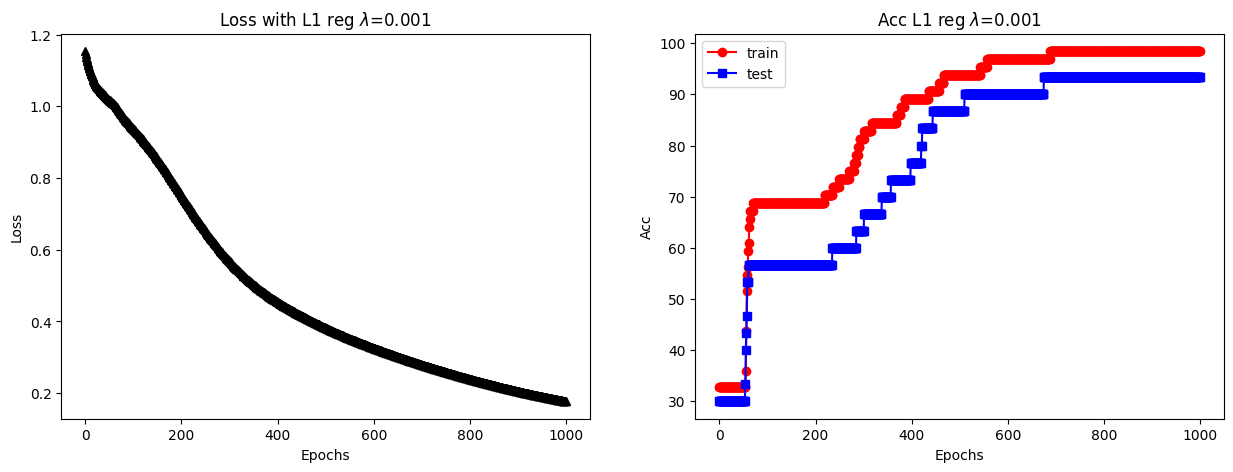

In [9]:
fig ,ax = plt.subplots(1,2,figsize = (15,5))

ax[0].plot(losses, 'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Loss with L1 reg $\lambda$=' + str(L1lambda))

ax[1].plot(trainAcc, 'ro-')
ax[1].plot(testAcc, 'bs-')
ax[1].set_ylabel('Acc')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Acc L1 reg $\lambda$=' + str(L1lambda))
ax[1].legend(['train','test'])

plt.show()